### Notebook 3 - Estimating the posterior parameter distribution of protein translation rate $\beta$ and protein decay rate $\delta$ using MCMC sampling

The purpose of this notebook is to exemplify the estimation procedure for one gene of choice - as robust estimation takes about 30-60 minutes per gene, the global parameter estimation was performed on a computational cluster using the same procedures. Additional pieces of code required for cluster runs can be found in the folder "cluster_code".

In [1]:
import numpy as np
import pandas as pd
import pickle
import emcee

# import custom functions
import MCMC_pipe
from importlib import reload
reload(MCMC_pipe)
from MCMC_pipe import protein_ODE, log_likelihood, log_prior, log_probability
from MCMC_pipe import plot_autocorr, plot_model_profiles, plot_corner
from MCMC_pipe import import_data

#### A) Data import

In [2]:
M_data, P_data, Psem_data, M_interp_dict, beta_gamma_dist, delta_gamma_dist, start_values = import_data()

#### B) Parameter estimation procedure and plots for one example gene

In [3]:
# chose a gene to estimate parameters for
gene = 'Reg3g'
# define time vector
time_vec = np.linspace(0, 96, 6)

In [4]:
# get data for this gene as array
protein_vals = P_data.loc[gene].values
protein_errors = Psem_data.loc[gene].values
mRNA_vals = M_data.loc[gene].values
mRNA_fun = M_interp_dict[gene]
log_beta_0 = np.log(start_values.loc[gene]['beta_0'])
log_delta_0 = np.log(start_values.loc[gene]['delta_0'])

In [5]:
# initialize sampling ensemble with 32 walkers
nwalkers = 32
ndim = 3
# as starting values, use beta and delta values from
# a preliminary run and the experimental protein values in V1
pos = np.array([log_beta_0, log_delta_0, protein_vals[0]]) \
    + 1e-4 * np.random.randn(nwalkers, ndim)

# choose how many steps to run the chain for (I recommend 
# 500 for testing code, 6000 for production, burn-in and thinning
# may need to be adjusted below)
nsteps = 6000

# sample!
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                args=(time_vec, protein_vals,
                                      protein_errors, mRNA_fun,
                                      beta_gamma_dist, delta_gamma_dist))
res = sampler.run_mcmc(pos, nsteps, progress=True)

100%|██████████| 6000/6000 [33:20<00:00,  3.00it/s]  


In [6]:
# choose length of burn-in period and thinning parameter
# paper results use discard=500 and thin=15 for chain length of 6000
discard = 500
thin = 15

# extract MCMC chains from sampler object
flat_samples = sampler.get_chain(discard=discard, thin=thin, flat=True)
flat_probs = sampler.get_log_prob(discard=discard, thin=thin, flat=True)

# store thinned results in a dataframe and export
sample_df = pd.DataFrame(data=np.hstack((flat_samples,
                                        flat_probs.reshape((-1, 1)))),
                         columns=['log_beta', 'log_delta', 'Pzero', 'log_prob'])
sample_df.to_csv('MCMC_results/{}_chain_sample.csv'.format(gene))

beta_mode = np.exp(
    sample_df.iloc[sample_df['log_prob'].argmax()]['log_beta'])
delta_mode = np.exp(
    sample_df.iloc[sample_df['log_prob'].argmax()]['log_delta'])
Pzero_mode = sample_df.iloc[sample_df['log_prob'].argmax()]['Pzero']
print(beta_mode, delta_mode, Pzero_mode)

25.837399957936185 0.023305363821794763 156488.02333716783


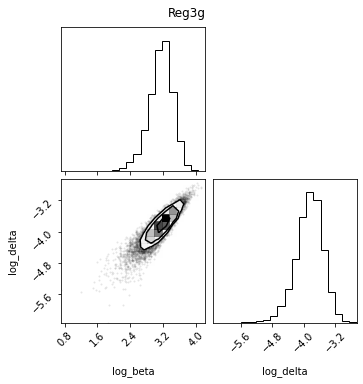

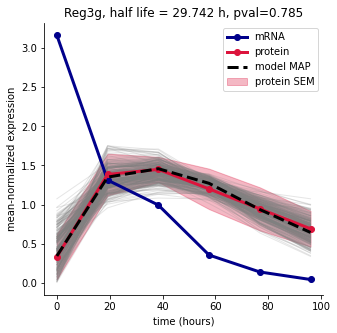

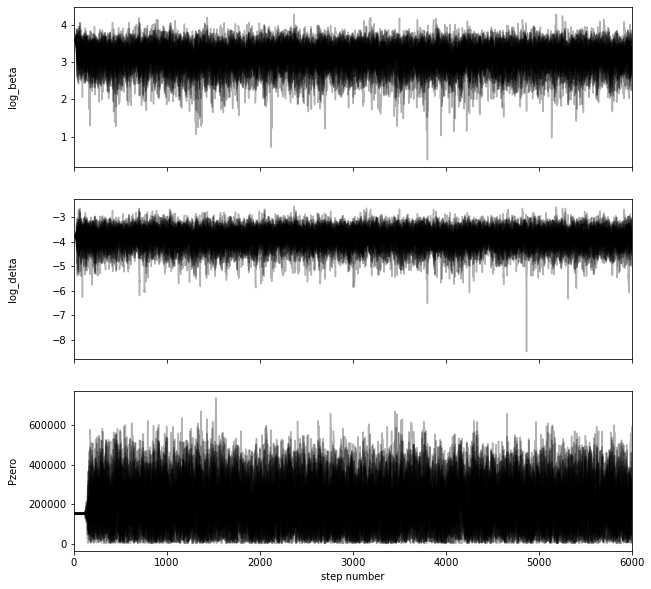

In [7]:
# produce corner plot, model profiles and MCMC autocorrelation plot
plot_corner(gene, flat_samples, show=True)

# some heavier computation is done within this plot so it may take some time
plot_model_profiles(gene,
                    sample_df,
                    M_data.loc[gene].values,
                    P_data.loc[gene].values,
                    Psem_data.loc[gene].values,
                    M_interp_dict[gene],
                    show=True)

plot_autocorr(gene, sampler, show=True)